In [1]:
# Clone the GitHub repository
!git clone https://github.com/HWhr3000/F21DL_Coursework_grp2.git

# Access the train and validation folders
!ls F21DL_Coursework_grp2/data/train
!ls F21DL_Coursework_grp2/data/validation

Cloning into 'F21DL_Coursework_grp2'...
remote: Enumerating objects: 34635, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 34635 (delta 65), reused 74 (delta 32), pack-reused 34506 (from 1)
Receiving objects: 100% (34635/34635), 185.73 MiB | 22.19 MiB/s, done.
Resolving deltas: 100% (330/330), done.
Updating files: 100% (36019/36019), done.
angry  disgust	fear  happy  neutral  sad  surprise
angry  disgust	fear  happy  neutral  sad  surprise


In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os
import copy

In [3]:
# Visualization libraries
import seaborn as sns

In [4]:
# Image dimensions and batch size
IMG_HEIGHT = 56
IMG_WIDTH = 56
BATCH_SIZE = 128

In [5]:
#Number of possible label values (emotions)
nb_classes = 7

In [6]:
# Path for datasets
train_path = "F21DL_Coursework_grp2/data/train"
validation_path = "F21DL_Coursework_grp2/data/validation"

In [7]:
import os

# Define a function to remove .DS_Store files
def remove_ds_store(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == ".DS_Store":
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed: {file_path}")

# Apply to your dataset directory
remove_ds_store("F21DL_Coursework_grp2/data/train")
remove_ds_store("F21DL_Coursework_grp2/data/validation")

Removed: F21DL_Coursework_grp2/data/train/.DS_Store
Removed: F21DL_Coursework_grp2/data/validation/.DS_Store


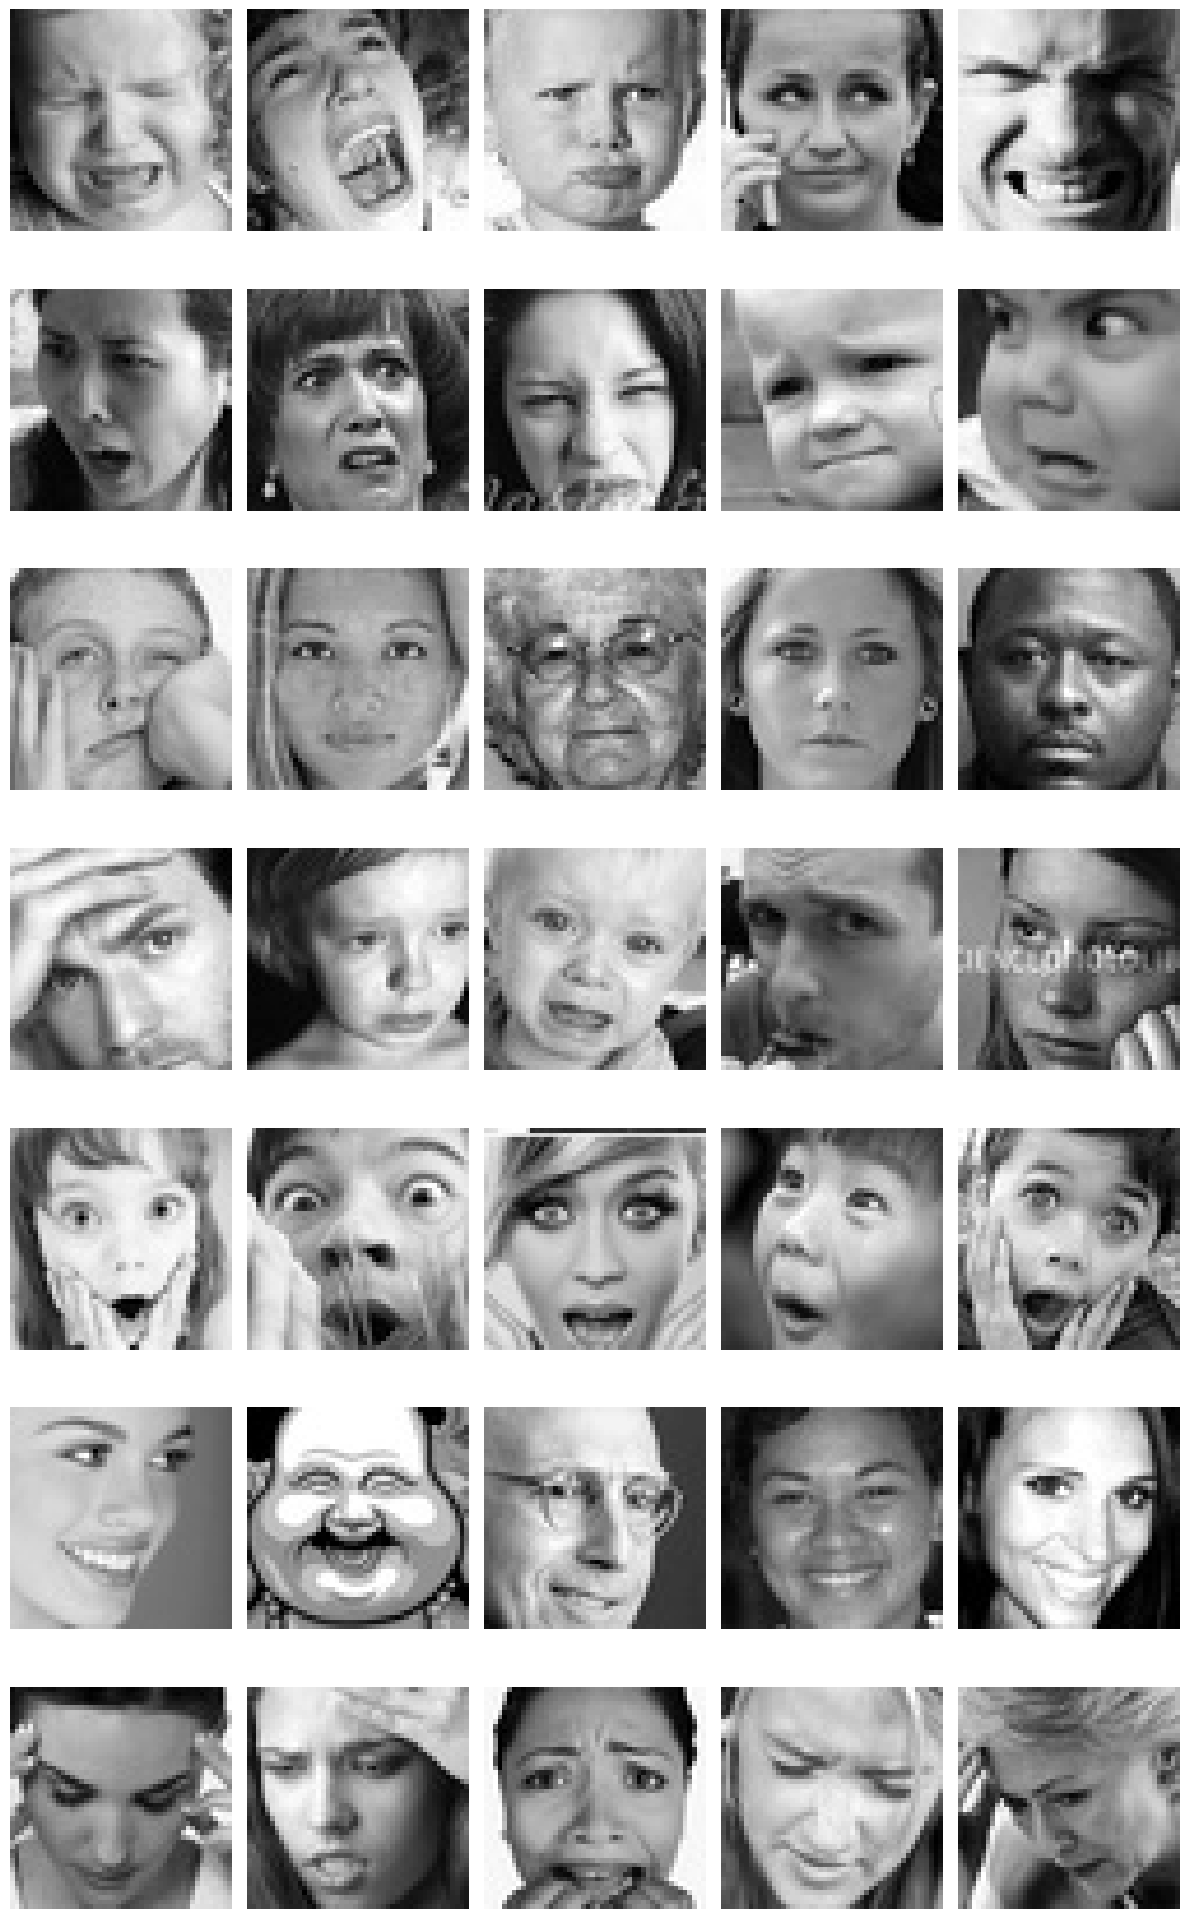

In [8]:
# Step 1: Visualize the dataset
# Display a few images from each expression category
plt.figure(0, figsize=(12, 20))
cpt = 0  # Counter for subplot placement
for expression in os.listdir(train_path):
    for i in range(1, 6):  # Display 5 images per category
        cpt += 1
        plt.subplot(7, 5, cpt)  # 7 rows, 5 columns
        img = cv2.imread(f"{train_path}/{expression}/{os.listdir(train_path + '/' + expression)[i]}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        plt.imshow(img, cmap="gray")
        plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show()

In [9]:
# Step 2: Create Data Generators for Training and Validation
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True
)

In [10]:
# Only rescaling for validation
validation_datagen = ImageDataGenerator(rescale=1.0/255)

In [11]:
# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 28821 images belonging to 7 classes.


In [12]:
# Validation data generator
validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 7066 images belonging to 7 classes.


In [13]:
# Step 3: Build the CNN Model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolutional Layer
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolutional Layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolutional Layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten the output
model.add(Flatten())

# Fully Connected Layer 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully Connected Layer 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output Layer
model.add(Dense(nb_classes, activation='softmax'))

# Print model summary
print(model.summary())

# Compile the model
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 56, 56, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

None


In [ ]:
# Step 4: Train the Model
epochs = 50  # Number of epochs

# Save the best model using a checkpoint
checkpoint = ModelCheckpoint("model_weights.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=callbacks_list
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2016 - loss: 2.1300
Epoch 1: val_accuracy improved from -inf to 0.25923, saving model to model_weights.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 2154s 10s/step - accuracy: 0.2016 - loss: 2.1297 - val_accuracy: 0.2592 - val_loss: 1.8699
Epoch 2/50
  1/225 ━━━━━━━━━━━━━━━━━━━━ 35:17 9s/step - accuracy: 0.2266 - loss: 1.9702

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.25923
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2266 - loss: 1.9702 - val_accuracy: 0.0000e+00 - val_loss: 3.2638
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2428 - loss: 1.9327
Epoch 3: val_accuracy did not improve from 0.25923
225/225 ━━━━━━━━━━━━━━━━━━━━ 2077s 9s/step - accuracy: 0.2428 - loss: 1.9326 - val_accuracy: 0.1730 - val_loss: 1.9348
Epoch 4/50
  1/225 ━━━━━━━━━━━━━━━━━━━━ 35:14 9s/step - accuracy: 0.1641 - loss: 2.0330
Epoch 4: val_accuracy did not improve from 0.25923
225/225 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - accuracy: 0.1641 - loss: 2.0330 - val_accuracy: 0.0000e+00 - val_loss: 3.3113
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2577 - loss: 1.8710
Epoch 5: val_accuracy improved from 0.25923 to 0.30469, saving model to model_weights.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 2122s 9s/step - accuracy: 0.2577 - loss: 1.8709 - val_accuracy: 0.3047 - val_loss: 1.7665
Epoch 6/50
 

Model stopped running, so loaded a saved version of the model to continue running it

In [15]:
from keras.callbacks import ModelCheckpoint

# Define the checkpoint to save the best model
checkpoint = ModelCheckpoint(
    "model_weights.keras",  # Path to save the best model
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Create the callbacks list
callbacks_list = [checkpoint]

In [16]:
from keras.models import load_model

# Load the saved model
model = load_model("F21DL_Coursework_grp2/data/model_weights.keras")

# Resume training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=5,  # Adjust based on remaining epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=callbacks_list
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3358 - loss: 1.7040
Epoch 1: val_accuracy improved from -inf to 0.36605, saving model to model_weights.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 1985s 9s/step - accuracy: 0.3358 - loss: 1.7039 - val_accuracy: 0.3661 - val_loss: 1.7373
Epoch 2/5
  1/225 ━━━━━━━━━━━━━━━━━━━━ 32:57 9s/step - accuracy: 0.3438 - loss: 1.6687

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.36605 to 0.38462, saving model to model_weights.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.3438 - loss: 1.6687 - val_accuracy: 0.3846 - val_loss: 2.1530
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3473 - loss: 1.6613
Epoch 3: val_accuracy improved from 0.38462 to 0.40014, saving model to model_weights.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 1977s 9s/step - accuracy: 0.3473 - loss: 1.6613 - val_accuracy: 0.4001 - val_loss: 1.5679
Epoch 4/5
  1/225 ━━━━━━━━━━━━━━━━━━━━ 27:37 7s/step - accuracy: 0.3984 - loss: 1.6107
Epoch 4: val_accuracy improved from 0.40014 to 0.61538, saving model to model_weights.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.3984 - loss: 1.6107 - val_accuracy: 0.6154 - val_loss: 1.3938
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3727 - loss: 1.6175
Epoch 5: val_accuracy did not improve from 0.61538
225/225 ━━━━━━━━━━━━━━━━━━━━ 1927s 9s/step - accuracy: 0.3727 -

In [17]:
from keras.models import load_model

# Load the previously saved model
model = load_model("model_weights.keras")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=5,  # Total epochs ()
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=callbacks_list  # Ensure callbacks are redefined
)

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3612 - loss: 1.6339
Epoch 1: val_accuracy did not improve from 0.61538
225/225 ━━━━━━━━━━━━━━━━━━━━ 1935s 9s/step - accuracy: 0.3612 - loss: 1.6338 - val_accuracy: 0.4214 - val_loss: 1.5002
Epoch 2/5
  1/225 ━━━━━━━━━━━━━━━━━━━━ 26:57 7s/step - accuracy: 0.3359 - loss: 1.6942
Epoch 2: val_accuracy improved from 0.61538 to 0.69231, saving model to model_weights.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.3359 - loss: 1.6942 - val_accuracy: 0.6923 - val_loss: 1.2884
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3800 - loss: 1.5935
Epoch 3: val_accuracy did not improve from 0.69231
225/225 ━━━━━━━━━━━━━━━━━━━━ 1914s 8s/step - accuracy: 0.3800 - loss: 1.5935 - val_accuracy: 0.4293 - val_loss: 1.4585
Epoch 4/5
  1/225 ━━━━━━━━━━━━━━━━━━━━ 29:32 8s/step - accuracy: 0.4141 - loss: 1.5544
Epoch 4: val_accuracy did not improve from 0.69231
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - accuracy: 0.

In [19]:
from keras.models import load_model

# Load the previously saved model
model = load_model("model_weights.keras")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=2,  # Total epochs (e.g)
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=callbacks_list  # Ensure callbacks are redefined
)

Epoch 1/2
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3781 - loss: 1.5958
Epoch 1: val_accuracy did not improve from 0.69231
225/225 ━━━━━━━━━━━━━━━━━━━━ 1930s 9s/step - accuracy: 0.3781 - loss: 1.5958 - val_accuracy: 0.4200 - val_loss: 1.4901
Epoch 2/2
  1/225 ━━━━━━━━━━━━━━━━━━━━ 32:14 9s/step - accuracy: 0.3594 - loss: 1.6057
Epoch 2: val_accuracy did not improve from 0.69231
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.3594 - loss: 1.6057 - val_accuracy: 0.6538 - val_loss: 1.0662


In [20]:
# Step 5: Visualize Training Results
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

In [21]:
# Function to find the best epoch
def get_best_epoch(history):
    val_acc = history.history['val_accuracy']
    best_epoch = val_acc.index(max(val_acc)) + 1
    best_acc = max(val_acc)
    print(f'Best Validation Accuracy Score: {best_acc:.5f}, at Epoch: {best_epoch}')
    return best_epoch

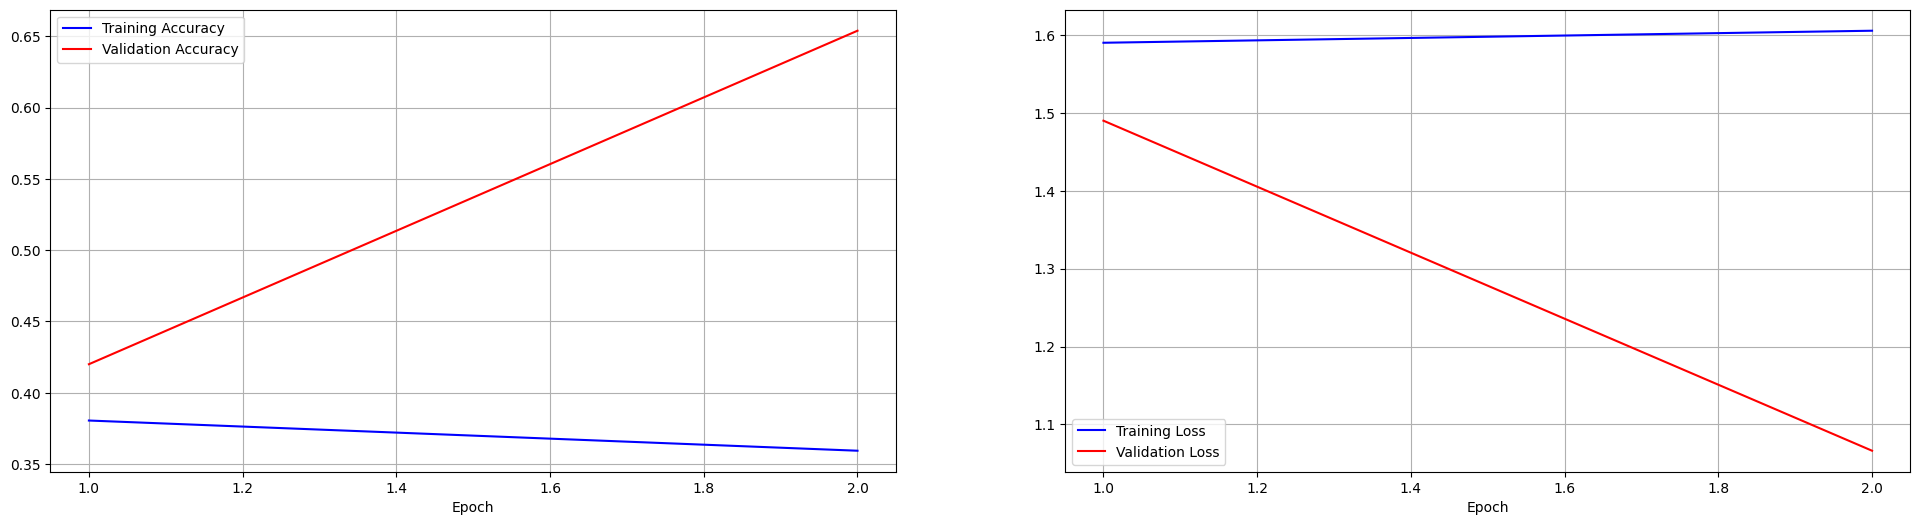

Best Validation Accuracy Score: 0.65385, at Epoch: 2


In [22]:
# Plot training results and best epoch
plot_results(history)
best_epoch = get_best_epoch(history)

Training was conducted in multiple stages (e.g., loading models and continuing training), which could have affected the learning curve.

# **Test Model and Display Predictions**

55/55 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step


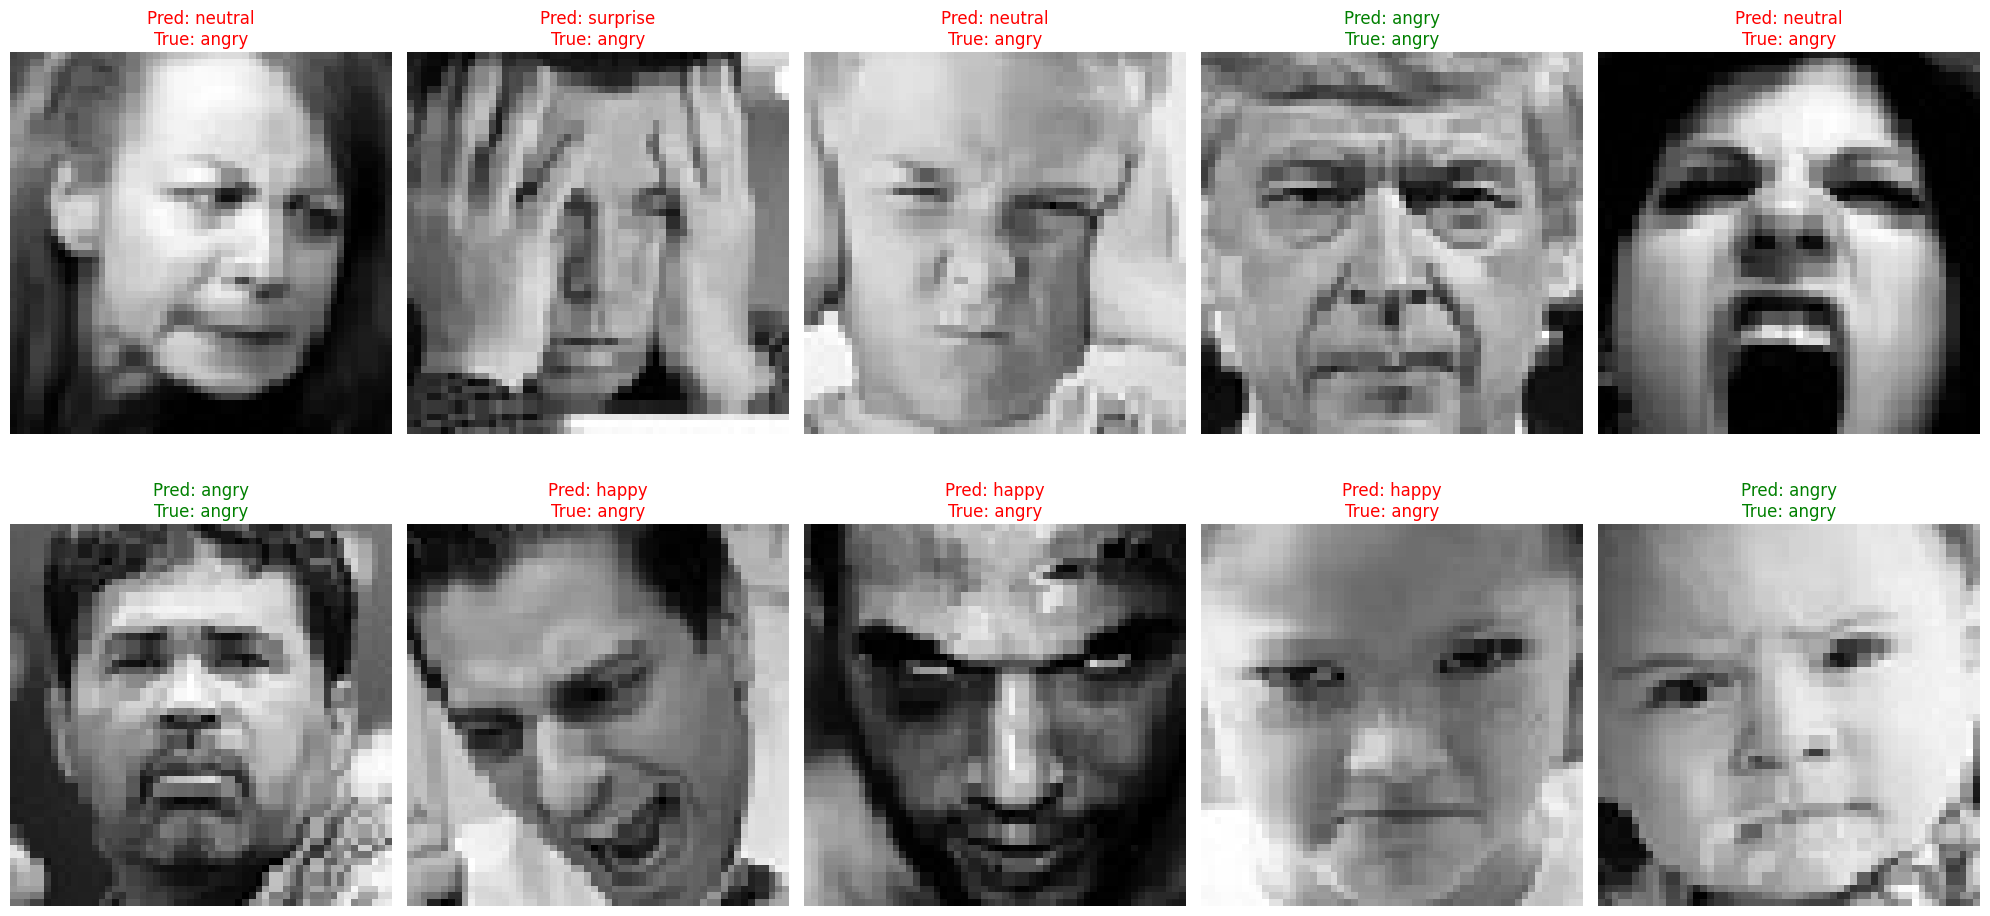

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
from keras.models import load_model
model = load_model("model_weights.keras")

# Predict on the validation set
predictions = model.predict(validation_generator, steps=validation_generator.n // validation_generator.batch_size)

# Convert predictions and true labels to readable formats
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())  # Class labels

# Visualize predictions
def visualize_predictions(generator, predicted_classes, true_classes, class_labels, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        # Get the image and true label from the generator
        img, _ = generator[i // generator.batch_size]  # Get a batch
        img_index = i % generator.batch_size  # Index within the batch

        plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns

        # Display the image
        plt.imshow(img[img_index].squeeze(), cmap="gray")

        # Get predicted and true labels for the current image
        pred_label = class_labels[predicted_classes[i]]
        true_label = class_labels[true_classes[i]]

        # Set the title with predicted and true labels
        color = "green" if pred_label == true_label else "red"
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to visualize predictions
visualize_predictions(validation_generator, predicted_classes, true_classes, class_labels)

# **Test across Angry**

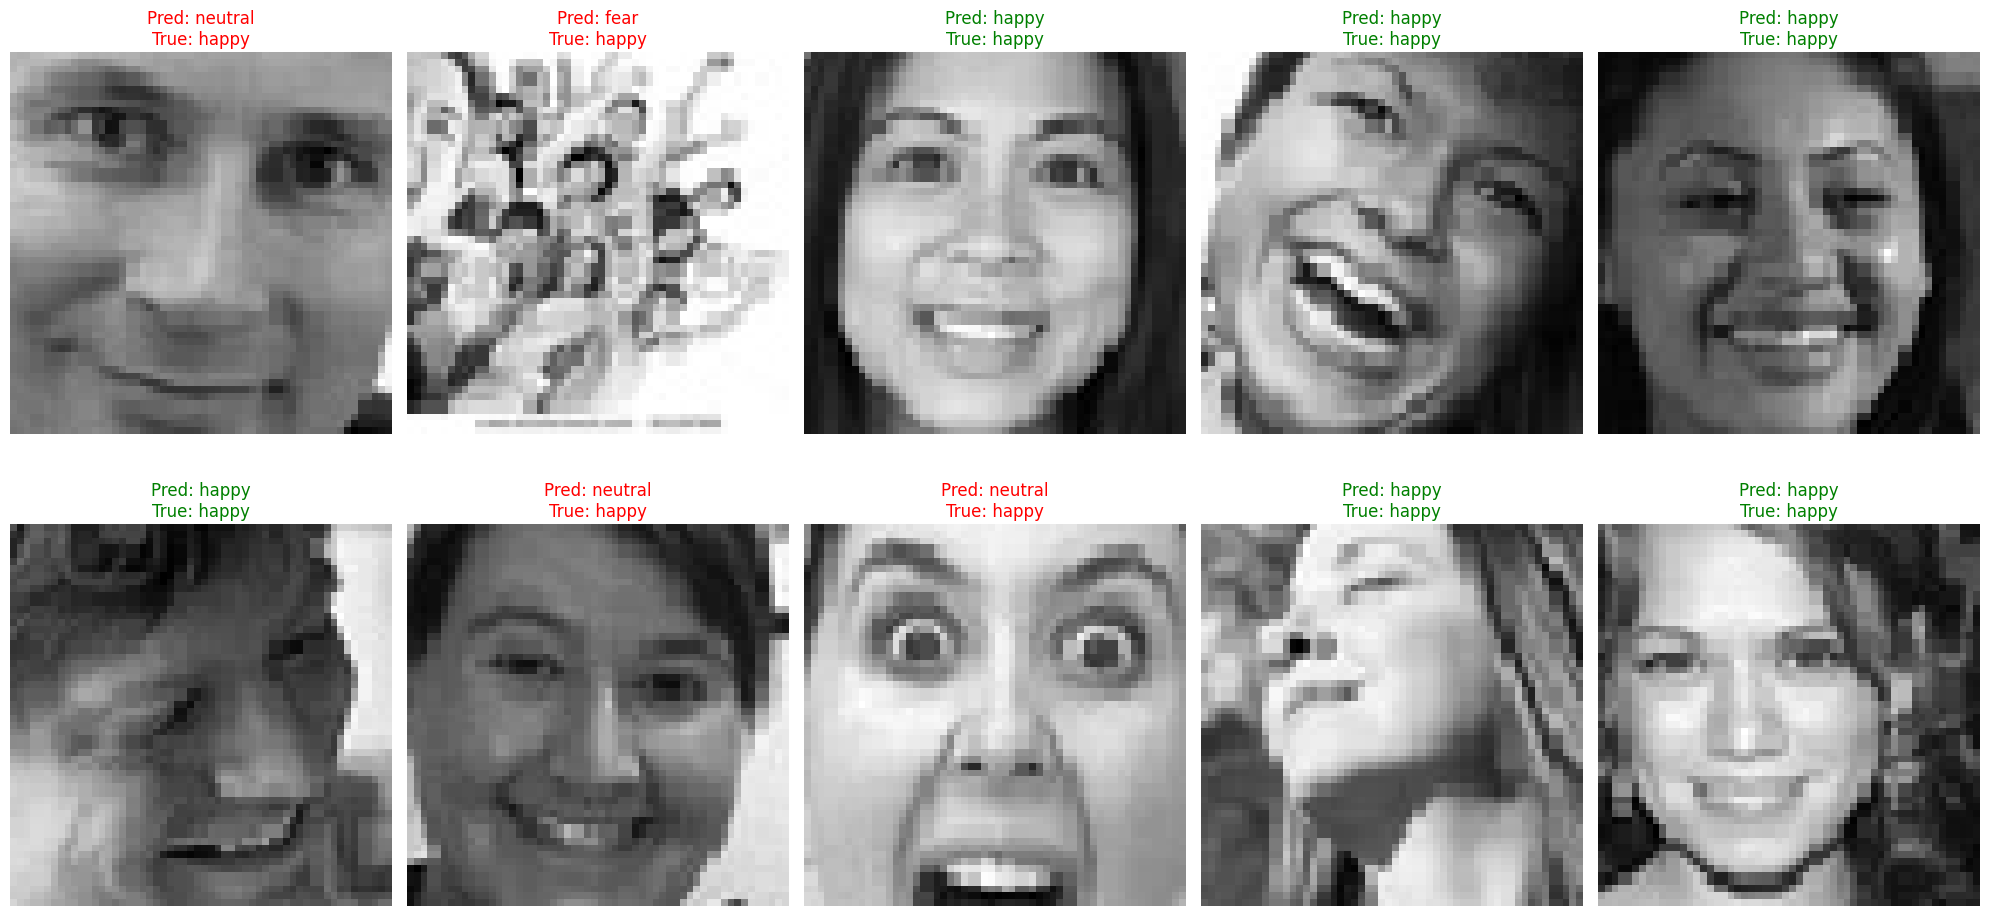

In [25]:
def visualize_specific_class(generator, predicted_classes, true_classes, class_labels, target_class, num_images=10):
    target_class_idx = class_labels.index(target_class)  # Index of the target class
    plt.figure(figsize=(20, 10))

    count = 0
    for i, true_label in enumerate(true_classes):
        if true_label == target_class_idx and count < num_images:  # Check for target class
            img, _ = generator[i // generator.batch_size]  # Get the batch
            img_index = i % generator.batch_size  # Index within the batch

            plt.subplot(2, 5, count + 1)  # 2 rows, 5 columns
            plt.imshow(img[img_index].squeeze(), cmap="gray")

            pred_label = class_labels[predicted_classes[i]]
            true_label_name = class_labels[true_label]

            # Set title
            color = "green" if pred_label == true_label_name else "red"
            plt.title(f"Pred: {pred_label}\nTrue: {true_label_name}", color=color)
            plt.axis('off')

            count += 1  # Increment count
    plt.tight_layout()
    plt.show()

# Call the function to visualize only "happy" class
visualize_specific_class(validation_generator, predicted_classes, true_classes, class_labels, target_class="happy")

# **Test across all classes**

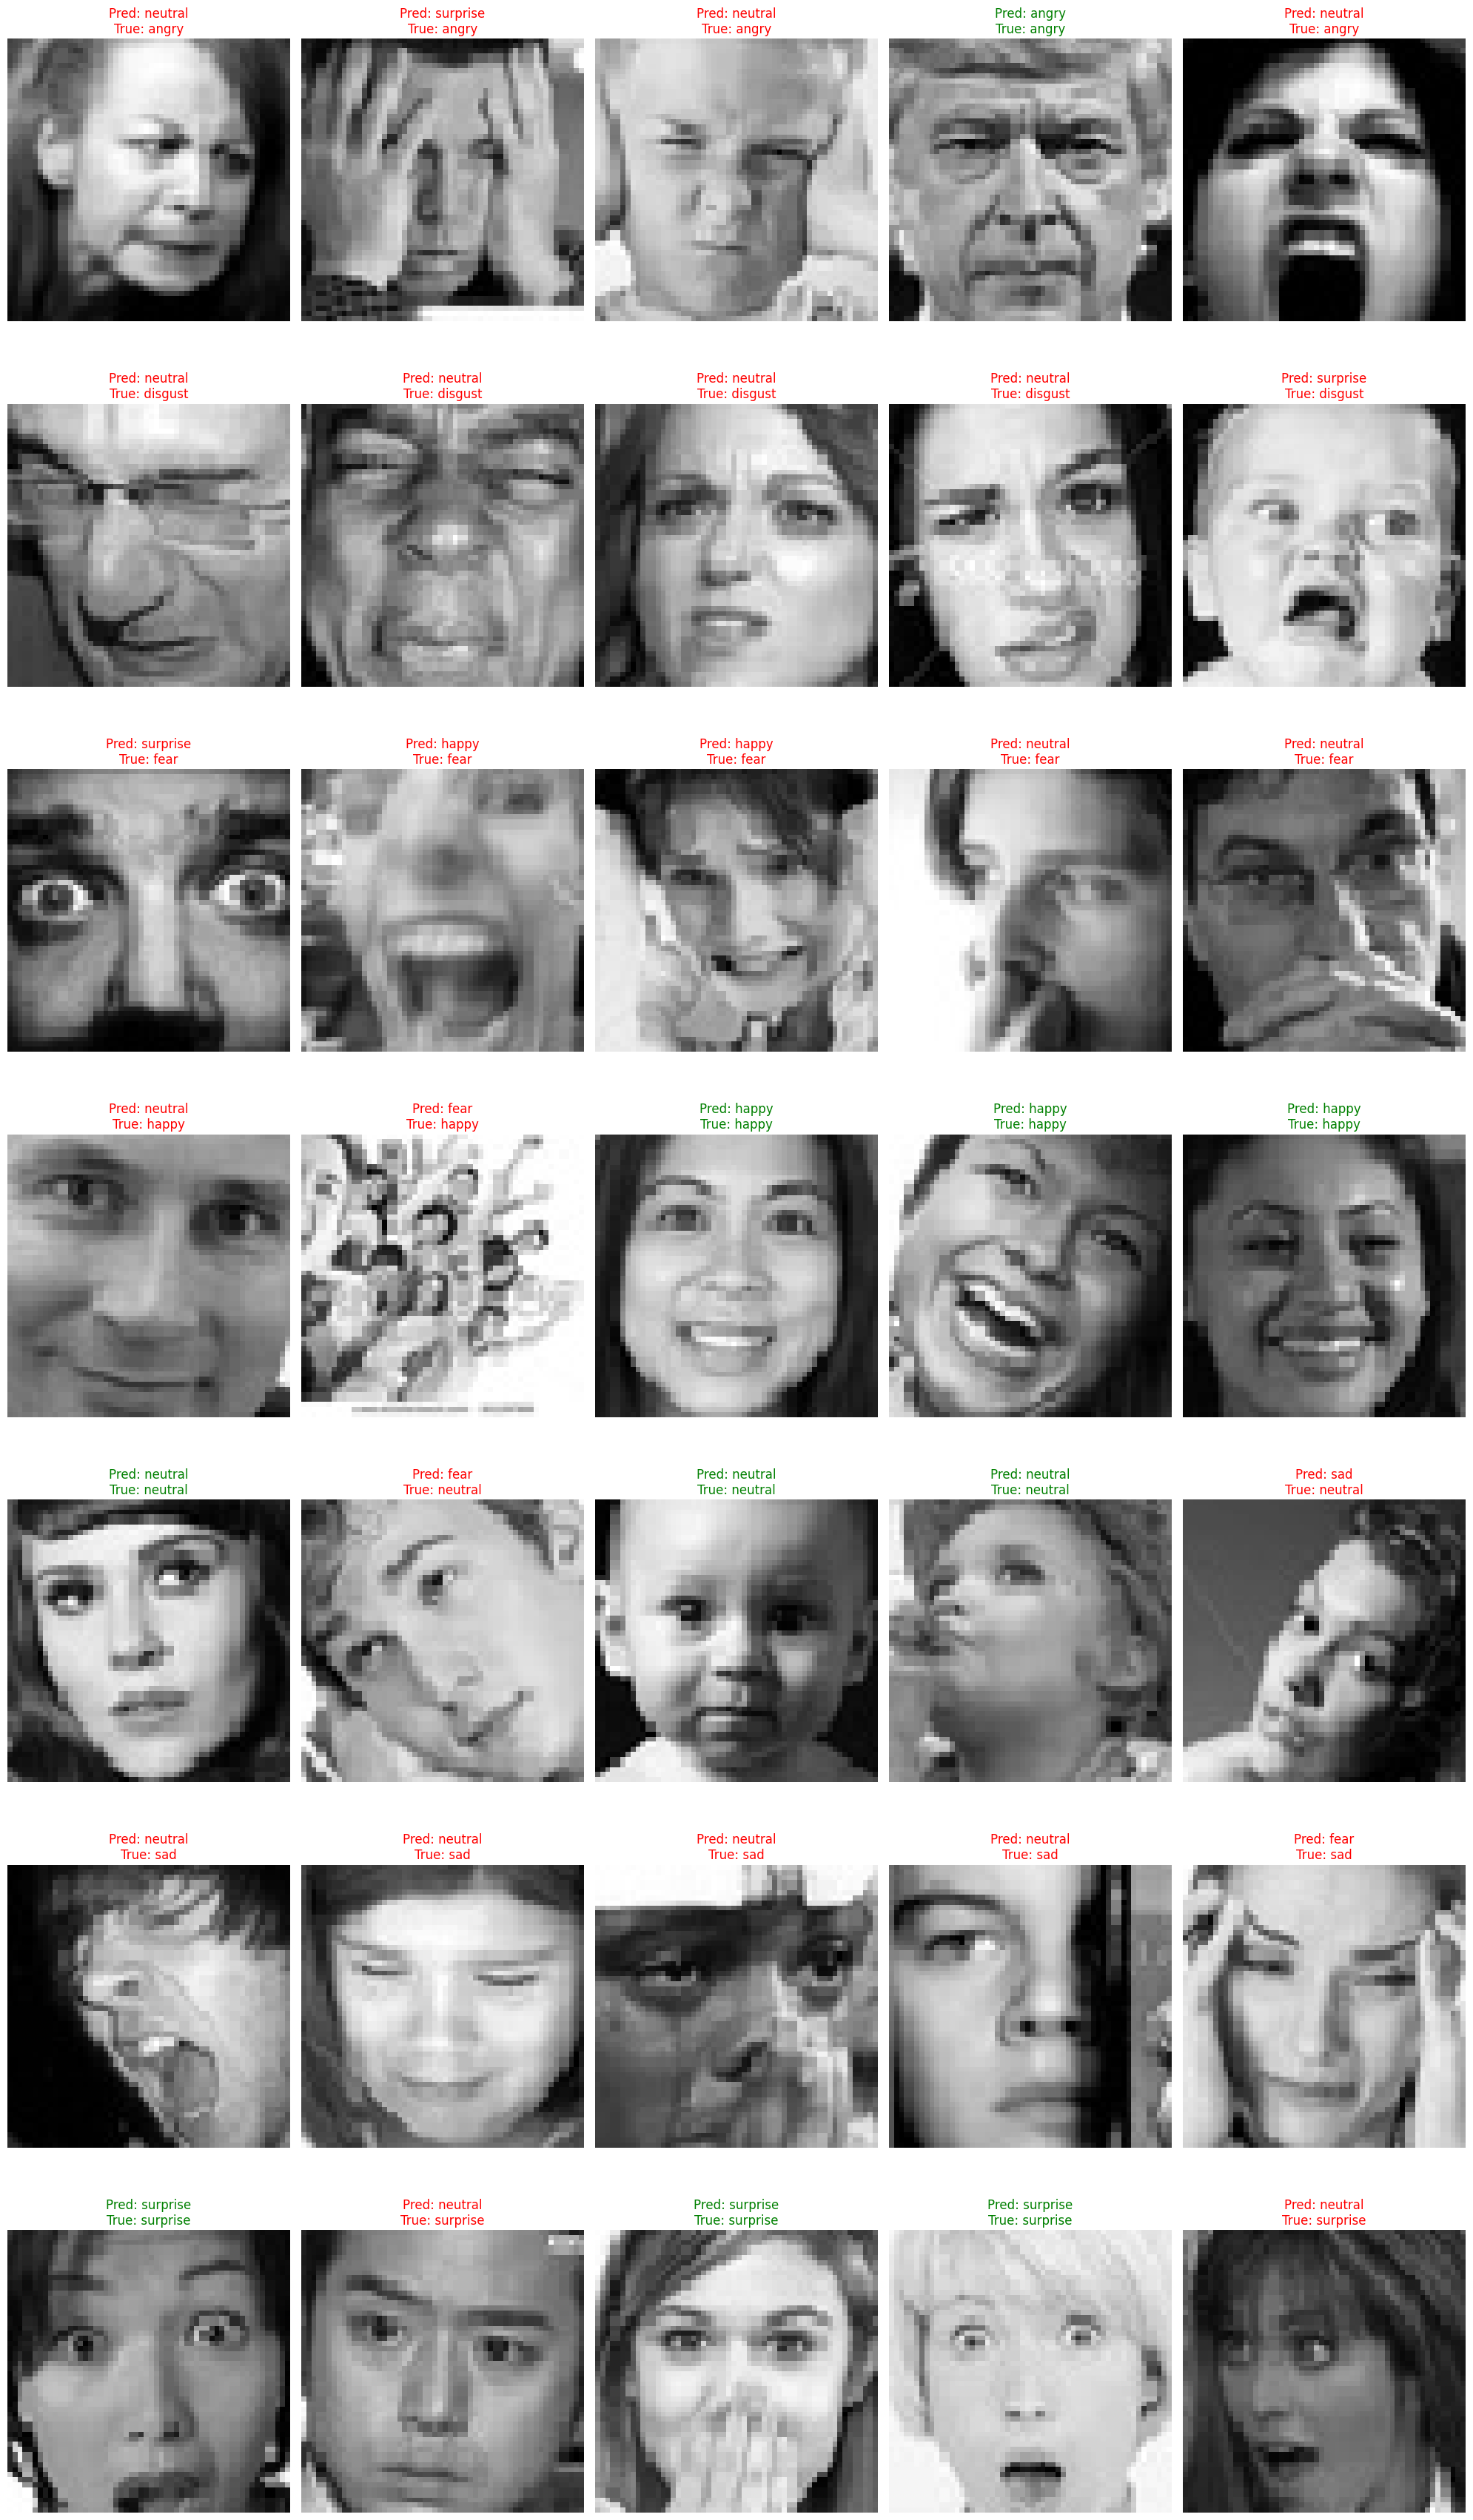

In [26]:
def visualize_all_classes(generator, predicted_classes, true_classes, class_labels, num_images_per_class=5):
    plt.figure(figsize=(20, len(class_labels) * 5))  # Adjust figure size for all classes

    for class_idx, class_name in enumerate(class_labels):
        count = 0  # Count images per class
        for i, true_label in enumerate(true_classes):
            if true_label == class_idx and count < num_images_per_class:  # Check for current class
                img, _ = generator[i // generator.batch_size]  # Get the batch
                img_index = i % generator.batch_size  # Index within the batch

                plt.subplot(len(class_labels), num_images_per_class, class_idx * num_images_per_class + count + 1)
                plt.imshow(img[img_index].squeeze(), cmap="gray")

                pred_label = class_labels[predicted_classes[i]]
                true_label_name = class_labels[true_label]

                # Set title
                color = "green" if pred_label == true_label_name else "red"
                plt.title(f"Pred: {pred_label}\nTrue: {true_label_name}", color=color)
                plt.axis('off')

                count += 1  # Increment count
    plt.tight_layout()
    plt.show()

# Call the function to visualize all classes
visualize_all_classes(validation_generator, predicted_classes, true_classes, class_labels)

# **Real-time Emotion Detection with OpenCV**

In [27]:
from keras.models import load_model

# Load the saved model
model_file = "model_weights.keras"
loaded_model = load_model(model_file)

# Print model summary to confirm successful loading
print("Model loaded successfully!")
loaded_model.summary()

Model loaded successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 56, 56, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 13,428,247 (51.22 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

 Optimizer params: 8,949,520 (34.14 MB)

In [36]:
import cv2
import numpy as np
from keras.models import load_model

In [37]:
# Load Haar Cascade for face detection
haarcascade_path = "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(haarcascade_path)

In [38]:
# Class labels
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [39]:
# Start webcam capture
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not access the webcam.")
else:
    print("Webcam started successfully!")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame. Exiting...")
        break

    # Convert frame to grayscale for Haar Cascade
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        fc = gray[y:y + h, x:x + w]
        roi = cv2.resize(fc, (48, 48))
        roi = roi.astype('float32') / 255.0  # Normalize
        roi = np.expand_dims(roi, axis=0)
        roi = np.expand_dims(roi, axis=-1)  # For grayscale channel

        # Predict emotion
        pred = model.predict(roi)
        label = class_labels[np.argmax(pred)]

        # Display prediction on the video
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Show the video feed with predictions
    cv2.imshow("Emotion Detection", frame)

    # Quit the loop by pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Error: Could not access the webcam.


error: OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


**(Needs to be run locally for webcam to show)**


# **Summary: Optimized CNN Model for Emotion Detection**

## 1. Model Architecture
- **Deeper Layers**: 4 convolutional layers with filters (64, 128, 512) for better feature extraction.
- **Batch Normalization**: Stabilized learning and improved convergence.
- **Activation Function**: ReLU for efficient non-linear transformations.
- **Dropout**: Rates of 0.25–0.5 to reduce overfitting.
- **Fully Connected Layers**: Two dense layers (256 and 512 neurons) for high-level feature processing.
- **Output Layer**: Softmax activation for multi-class emotion classification.

## 2. Preprocessing
- Resized input images to **56x56 (grayscale)** to simplify computation.
- Used **ImageDataGenerator** for:
  - Normalization (rescale pixel values to [0, 1]).
  - Data augmentation (rotation, shifting, flipping) for better generalization.

## 3. Hyperparameter Tuning
- **Learning Rate**: Reduced to 0.0001 with Adam optimizer for stable updates.
- **Batch Size**: Set to 128 for balance between speed and memory.
- **Epochs**: Increased to 50 with validation monitoring for optimal performance.

## 4. Training and Evaluation
- **Validation Monitoring**: Saved the model with the best validation accuracy using `ModelCheckpoint`.
- **Visualization**: Plotted accuracy and loss trends to monitor progress and identify the best epoch.

## 5. Real-time Integration
- **OpenCV Integration**: Used Haar Cascade for face detection.
- **Emotion Prediction**: Softmax output for 7 classes (Angry, Disgust, Fear, Happy, Neutral, Sad, Surprise).

## Key Benefits
- **Higher Accuracy**: Improved feature extraction with deeper layers and augmentation.
- **Reduced Overfitting**: Batch normalization and dropout enhanced generalization.
- **Efficient and Scalable**: Grayscale preprocessing made it suitable for real-time applications.